In [ ]:
# unzipping the GloVe directory from google drive
!unzip "/content/drive/My Drive/Copy of glove.6B.100d.txt.zip"

Archive:  /content/drive/My Drive/Copy of glove.6B.100d.txt.zip
  inflating: glove.6B.100d.txt       


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#Loading all the dependencies 



# print(device_lib.list_local_devices())

# Basic libraries 
import numpy as np
import pandas as pd
from collections import defaultdict
import re

# For data Preprocessing
from bs4 import BeautifulSoup

#For system
import sys
import os

# Deep Learning API dependencies

import keras
from tensorflow.python.client import device_lib

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Concatenate, Dropout, LSTM
from keras.models import Model
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization

MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 200000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

Using TensorFlow backend.


In [ ]:
#Loading dataset
data_train = pd.read_csv("/content/drive/My Drive/Copy of gossipcop_fake (1).csv")

In [ ]:
# Shape of the dataset gives number of rows and columns respectiveley in a .csv format dataset. 
data_train.shape

(23701, 5)

In [ ]:
data_train.head()

,id,news_url,title,tweet_ids,label
0,gossipcop-2493749932,www.dailymail.co.uk/tvshowbiz/article-5874213/...,Did Miley Cyrus and Liam Hemsworth secretly ge...,284329075902926848\t284332744559968256\t284335...,0.0
1,gossipcop-4580247171,hollywoodlife.com/2018/05/05/paris-jackson-car...,Paris Jackson & Cara Delevingne Enjoy Night Ou...,992895508267130880\t992897935418503169\t992899...,0.0
2,gossipcop-941805037,variety.com/2017/biz/news/tax-march-donald-tru...,Celebrities Join Tax March in Protest of Donal...,853359353532829696\t853359576543920128\t853359...,0.0
3,gossipcop-2547891536,www.dailymail.co.uk/femail/article-3499192/Do-...,Cindy Crawford's daughter Kaia Gerber wears a ...,988821905196158981\t988824206556172288\t988825...,0.0
4,gossipcop-5476631226,variety.com/2018/film/news/list-2018-oscar-nom...,Full List of 2018 Oscar Nominations – Variety,955792793632432131\t955795063925301249\t955798...,0.0


In [ ]:
# Cleaning of the dataset by dropping all the null values, resetting the index to avoid any error. 
data_train = data_train.dropna()
data_train = data_train.reset_index(drop=True)

In [ ]:
#Preprocessing of dataset for our model

print(data_train.columns)
print('What the raw input data looks like:')
print(data_train[0:5])
texts = []
labels = []

for i in range(data_train.title.shape[0]):
    
    text = data_train.title[i]
    
    texts.append(text)
    labels.append(data_train.label[i])
    
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Index(['id', 'news_url', 'title', 'tweet_ids', 'label'], dtype='object')
What the raw input data looks like:
                     id  ... label
0  gossipcop-2493749932  ...   0.0
1  gossipcop-4580247171  ...   0.0
2   gossipcop-941805037  ...   0.0
3  gossipcop-2547891536  ...   0.0
4  gossipcop-5476631226  ...   0.0

[5 rows x 5 columns]
Found 23294 unique tokens.


In [ ]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(labels),num_classes = 2)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (21335, 1000)
Shape of label tensor: (21335, 2)


In [ ]:
# Splitting of dataset 
from sklearn.model_selection import train_test_split

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
x_train, x_test, y_train, y_test = train_test_split( data, labels, test_size=0.15, random_state=42)
x_test, x_val, y_test, y_val = train_test_split( x_test, y_test, test_size=0.50, random_state=42)
print('Size of train, validation, test:', len(y_train), len(y_val), len(y_test))

print('real & fake news in train,valt,test:')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))
print(y_test.sum(axis=0))

Size of train, validation, test: 18134 1601 1600
real & fake news in train,valt,test:
[ 4447. 13687.]
[ 409. 1192.]
[ 411. 1189.]


In [ ]:
embeddings_index = {}
f = open(os.path.join('/content/glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    #print(values[1:])
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove.' % len(embeddings_index))

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH)


Total 400000 word vectors in Glove.


In [ ]:
#MODEL

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)

l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)

l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling

l_flat = Flatten()(l_pool3)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(2, activation='softmax')(l_dense)

model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='adadelta',
              metrics=['acc'])

print("Fitting the simple convolutional neural network model")
model.summary()
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=20, batch_size=128)

Fitting the simple convolutional neural network model
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         2329500   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 18134 samples, validate on 1601 samples
Epoch 1/20
18134/18134 [==============================] - 207s 11ms/step - loss: 0.5454 - acc: 0.7547 - val_loss: 0.4750 - val_acc: 0.7514
Epoch 2/20
18134/18134 [==============================] - 203s 11ms/step - loss: 0.4757 - acc: 0.7844 - val_loss: 0.4177 - val_acc: 0.8120
Epoch 3/20
18134/18134 [==============================] - 203s 11ms/step - loss: 0.4263 - acc: 0.8122 - val_loss: 0.3921 - val_acc: 0.8207
Epoch 4/20
18134/18134 [==============================] - 207s 11ms/step - loss: 0.3881 - acc: 0.8308 - val_loss: 0.3928 - val_acc: 0.8276
Epoch 5/20
18134/18134 [==============================] - 203s 11ms/step - loss: 0.3558 - acc: 0.8488 - val_loss: 0.4362 - val_acc: 0.8007
Epoch 6/20
18134/18134 [==============================] - 203s 11ms/step - loss: 0.3150 - acc: 0.8663 - val_loss: 0.4924 - val_acc: 0.8020
Epoch 7/20
18134/18134 [==============================] - 207s 11ms/step - loss: 0.2788 - acc: 0.8862 - val_loss: 0.3

In [ ]:
model.save('SCNN.h5')

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


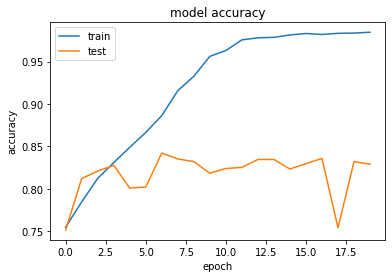

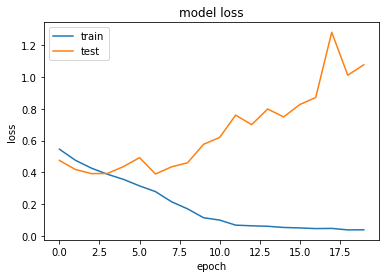

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Correct predictions: 1295.0
Total number of test examples: 1600
Accuracy of model1:  0.809375


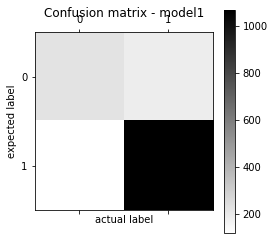

In [ ]:
# Test model 1
import matplotlib.pyplot as plt
test_preds = model.predict(x_test)
test_preds = np.round(test_preds)
correct_predictions = float(sum(test_preds == y_test)[0])
print("Correct predictions:", correct_predictions)
print("Total number of test examples:", len(y_test))
print("Accuracy of model1: ", correct_predictions/float(len(y_test)))

# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
x_pred = model.predict(x_test)
x_pred = np.round(x_pred)
x_pred = x_pred.argmax(1)
y_test_s = y_test.argmax(1)
cm = confusion_matrix(y_test_s, x_pred)
plt.matshow(cm, cmap=plt.cm.binary, interpolation='nearest')
plt.title('Confusion matrix - model1')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('actual label')
plt.show()

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.9152239260940246
Test accuracy: 0.8343883156776428


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("F1 score" + " : "  + str(f1_score(y_test_s, x_pred, average="macro")))
print("Precision score" + " : "  + str(precision_score(y_test_s, x_pred, average="macro")))
print("Recall score" + " : "  + str(recall_score(y_test_s, x_pred, average="macro")))   


F1 score : 0.7356410568940532
Precision score : 0.7529902977336691
Recall score : 0.7236805755925668
